In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import mutual_info_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import mutual_info_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

from xgboost import XGBClassifier

from sklearn.linear_model import Ridge

from IPython.display import display

print( 'Pandas version = ' + pd.__version__ + '\n' )

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

Pandas version = 2.1.0

The scikit-learn version is 1.3.1.


In [2]:
################################################################################
######  Read the data from the file  ###########################################
################################################################################

df = pd.read_csv('heart_attack_prediction_dataset.csv')
df.head()

,Patient ID,Age,Sex,Cholesterol,Blood Pressure,Heart Rate,Diabetes,Family History,Smoking,Obesity,...,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Country,Continent,Hemisphere,Heart Attack Risk
0,BMW7812,67,Male,208,158/88,72,0,0,1,0,...,6.615001,261404,31.251233,286,0,6,Argentina,South America,Southern Hemisphere,0
1,CZE1114,21,Male,389,165/93,98,1,1,1,1,...,4.963459,285768,27.194973,235,1,7,Canada,North America,Northern Hemisphere,0
2,BNI9906,21,Female,324,174/99,72,1,0,0,0,...,9.463426,235282,28.176571,587,4,4,France,Europe,Northern Hemisphere,0
3,JLN3497,84,Male,383,163/100,73,1,1,1,0,...,7.648981,125640,36.464704,378,3,4,Canada,North America,Northern Hemisphere,0
4,GFO8847,66,Male,318,91/88,93,1,1,1,1,...,1.514821,160555,21.809144,231,1,5,Thailand,Asia,Northern Hemisphere,0


In [3]:
################################################################################
######  Column Name  Cleanup ###################################################
################################################################################

df.columns = df.columns.str.replace(' ', '_').str.lower()
booleanColumns = [
    'diabetes',
    'family_history',
    'smoking',
    'obesity',
    'alcohol_consumption',
    'previous_heart_problems',
    'medication_use',
    'heart_attack_risk'
]
categoricalColums = [ 'sex', 'country', 'continent', 'hemisphere' ]

In [4]:
################################################################################
######  Data Cleanup ###########################################################
################################################################################

# Patient_id feature has no relevance for hart atack risk so drop it
# These two comlims 'continent' and 'hemisphere' are depemdent on country so delete them
# Obesity and BMI are redundant
# physical_activity_days_per_week is redundant with "exercise_hours_per_week". Removing physical_activity_days_per_week

ignoreDiastolicPressure = True

ignoredFeatures = [  'patient_id', 'continent', 'hemisphere', 'country', 'income', 'obesity', 
                'physical_activity_days_per_week', 'sedentary_hours_per_day', 'exercise_hours_per_week', 'previous_heart_problems',
                'diet', 'stress_level', 'sleep_hours_per_day', 'alcohol_consumption', 'diabetes', 'sex', 'medication_use', 'bmi',
                ]
for col in ignoredFeatures:
    del df[ col ]

In [5]:
########################################################################################################################
######  Transform 'sex' feature from 'Male' and 'Female' to 0 and 1 ####################################################
########################################################################################################################

if not 'sex' in ignoredFeatures:
    df['sex'] = df['sex'].astype("string")
    df['sex'] =  df['sex'].apply({'Male':1, 'Female':0}.get)
else:
    print( "Ignoring sex column" )
    print(df.columns)
df.head

Ignoring sex column
Index(['age', 'cholesterol', 'blood_pressure', 'heart_rate', 'family_history',
       'smoking', 'triglycerides', 'heart_attack_risk'],
      dtype='object')


<bound method NDFrame.head of       age  cholesterol blood_pressure  heart_rate  family_history  smoking  \
0      67          208         158/88          72               0        1   
1      21          389         165/93          98               1        1   
2      21          324         174/99          72               0        0   
3      84          383        163/100          73               1        1   
4      66          318          91/88          93               1        1   
...   ...          ...            ...         ...             ...      ...   
8758   60          121          94/76          61               1        1   
8759   28          120        157/102          73               0        0   
8760   47          250         161/75         105               1        1   
8761   36          178         119/67          60               0        1   
8762   25          356         138/67          75               1        0   

      triglycerides  heart_attack

In [6]:
########################################################################################################################
######  Split  blood_pressure into two new featuresnumerical 'blood_pressure_sistolic','blood_pressure_diastolic' ############
########################################################################################################################

df[['blood_pressure_sistolic','blood_pressure_diastolic']] = df.blood_pressure.str.split("/",expand=True) 
#print( df[ ['blood_pressure', 'blood_pressure_sistolic', 'blood_pressure_diastolic'] ] )

# data from 'blood_pressure' is now contained in 'blood_pressure_sistolic' and 'blood_pressure_diastolic' so it is redundant and must be deleted
del df[ 'blood_pressure' ]

df['blood_pressure_sistolic'] = pd.to_numeric(df['blood_pressure_sistolic'])
if not ignoreDiastolicPressure:
    df['blood_pressure_diastolic'] = pd.to_numeric(df['blood_pressure_diastolic'])
else:
    del  df['blood_pressure_diastolic']
    print( "Ignoring Diastolic Pressure")

print(df.columns)
#pd.set_option('display.max_columns', None)
display(df)
#df.head()

Ignoring Diastolic Pressure
Index(['age', 'cholesterol', 'heart_rate', 'family_history', 'smoking',
       'triglycerides', 'heart_attack_risk', 'blood_pressure_sistolic'],
      dtype='object')


,age,cholesterol,heart_rate,family_history,smoking,triglycerides,heart_attack_risk,blood_pressure_sistolic
0,67,208,72,0,1,286,0,158
1,21,389,98,1,1,235,0,165
2,21,324,72,0,0,587,0,174
3,84,383,73,1,1,378,0,163
4,66,318,93,1,1,231,0,91
...,...,...,...,...,...,...,...,...
8758,60,121,61,1,1,67,0,94
8759,28,120,73,0,0,617,0,157
8760,47,250,105,1,1,527,1,161
8761,36,178,60,0,1,114,0,119


In [7]:
if not 'diet' in ignoredFeatures:

    dfDietDummies = pd.get_dummies(df['diet'], prefix='diet', drop_first='True') 

    # Covert from Boolean to 0 and 1 
    dfDietDummies.replace({False: 0, True: 1}, inplace=True)

    df = pd.concat([df,dfDietDummies],axis=1)

    # now drop the original 'country' column (you don't need it anymore)
    df.drop(['diet'],axis=1, inplace=True)

    df.columns = df.columns.str.lower()
else:
    print( "Ignoring diet column" )
    print(df.columns)
    display( df )

Ignoring diet column
Index(['age', 'cholesterol', 'heart_rate', 'family_history', 'smoking',
       'triglycerides', 'heart_attack_risk', 'blood_pressure_sistolic'],
      dtype='object')


,age,cholesterol,heart_rate,family_history,smoking,triglycerides,heart_attack_risk,blood_pressure_sistolic
0,67,208,72,0,1,286,0,158
1,21,389,98,1,1,235,0,165
2,21,324,72,0,0,587,0,174
3,84,383,73,1,1,378,0,163
4,66,318,93,1,1,231,0,91
...,...,...,...,...,...,...,...,...
8758,60,121,61,1,1,67,0,94
8759,28,120,73,0,0,617,0,157
8760,47,250,105,1,1,527,1,161
8761,36,178,60,0,1,114,0,119


In [8]:
#oneHotEncoder = OneHotEncoder(drop='first')

if not 'country' in ignoredFeatures:
    dfCountryDummies = pd.get_dummies(df['country'], prefix='country', drop_first='True') 

    # Covert from Boolean to 0 nd 1 
    dfCountryDummies.replace({False: 0, True: 1}, inplace=True)

    df = pd.concat([df,dfCountryDummies],axis=1)

    df.columns = df.columns.str.lower()
    # now drop the original 'country' column (you don't need it anymore)
    df.drop(['country'],axis=1, inplace=True)
else:
    print( "Ignoring country column" )

print(df.columns)
display( df )

Ignoring country column
Index(['age', 'cholesterol', 'heart_rate', 'family_history', 'smoking',
       'triglycerides', 'heart_attack_risk', 'blood_pressure_sistolic'],
      dtype='object')


,age,cholesterol,heart_rate,family_history,smoking,triglycerides,heart_attack_risk,blood_pressure_sistolic
0,67,208,72,0,1,286,0,158
1,21,389,98,1,1,235,0,165
2,21,324,72,0,0,587,0,174
3,84,383,73,1,1,378,0,163
4,66,318,93,1,1,231,0,91
...,...,...,...,...,...,...,...,...
8758,60,121,61,1,1,67,0,94
8759,28,120,73,0,0,617,0,157
8760,47,250,105,1,1,527,1,161
8761,36,178,60,0,1,114,0,119


In [9]:
seed = 1

print (df.isna().any())

df_intermediate_train, df_test = train_test_split(df, test_size=0.2, random_state=seed)
df_full_train = df_intermediate_train.copy()
df_train, df_val = train_test_split(df_intermediate_train, test_size=0.25, random_state=seed)

y_train = df_train['heart_attack_risk'].values
y_full_train = df_full_train['heart_attack_risk'].values
y_val = df_val['heart_attack_risk'].values
y_test = df_test['heart_attack_risk'].values

del df_train['heart_attack_risk']
del df_full_train['heart_attack_risk']
del df_val['heart_attack_risk']
del df_test['heart_attack_risk']

df_train.info()

print ("##########################")
display( y_full_train )

age                        False
cholesterol                False
heart_rate                 False
family_history             False
smoking                    False
triglycerides              False
heart_attack_risk          False
blood_pressure_sistolic    False
dtype: bool
<class 'pandas.core.frame.DataFrame'>
Index: 5257 entries, 7969 to 3324
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   age                      5257 non-null   int64
 1   cholesterol              5257 non-null   int64
 2   heart_rate               5257 non-null   int64
 3   family_history           5257 non-null   int64
 4   smoking                  5257 non-null   int64
 5   triglycerides            5257 non-null   int64
 6   blood_pressure_sistolic  5257 non-null   int64
dtypes: int64(7)
memory usage: 328.6 KB
##########################


array([1, 0, 0, ..., 0, 1, 0])

In [10]:
treshHold=0.5

from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
logmodel.fit(df_train,y_train)

predictionsProba = logmodel.predict_proba(df_val)[:, 1]
predictions = [ value > treshHold for value in predictionsProba]
predictions = logmodel.predict(df_val)

accuracy = accuracy_score(y_val, predictions)
print( "Logistic Regression Accuracy=", accuracy )

Logistic Regression Accuracy= 0.6280661722760981


In [11]:
treshHold=0.5

from sklearn.linear_model import LogisticRegression
logmodel2 = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
logmodel2.fit(df_full_train,y_full_train)

#predictionsProba = logmodel.predict_proba(df_test)[:, 1]
#display(predictionsProba)
#predictions = [ value > treshHold for value in predictionsProba]
predictions = logmodel.predict(df_test)

display( predictions )
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1score = f1_score(y_test, predictions)


print(f"Precision = {precision}")
print(f"Recall = {recall}")
print(f"F1 Score = {f1score}")
print( "Logistic Full Train Regression Accuracy=", accuracy )

/home/midnightmover/machine-learning-zoomcamp/mlzoomcap-notebooks/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


array([0, 0, 0, ..., 0, 0, 0])

Precision = 0.0
Recall = 0.0
F1 Score = 0.0
Logistic Full Train Regression Accuracy= 0.6514546491728466


/home/midnightmover/machine-learning-zoomcamp/mlzoomcap-notebooks/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:
import warnings
warnings.simplefilter(action='ignore', category=Warning)

# fit model no training data
xgbModel = XGBClassifier(n_estimators = 500)
treshHold=0.5

xgbModel.set_params( eta=0.01 )
#model.set_params( max_depth=100 )
xgbModel.set_params( objective='binary:logistic' )
#model.set_params( subsample=0.99 )
#model.set_params( lammbda=0.01 )

xgbModel.fit(df_train, y_train)
# make predictions for test data
y_pred = xgbModel.predict(df_val)

display(y_pred)
#predictions = [round(value) for value in y_pred]
predictions = [ value > treshHold for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_val, predictions)
print( "XG Boost Accuracy=", accuracy )

array([0, 0, 0, ..., 0, 0, 0])

XG Boost Accuracy= 0.6177980604677695


In [13]:
# fit model no training data
xgbModel2 = XGBClassifier(n_estimators = 500)
xgbModel2.set_params( eta=0.01 )
xgbModel2.fit(df_full_train, y_full_train)
# make predictions for test data
y_pred = xgbModel2.predict(df_test)
y_pred_proba = xgbModel2.predict_proba(df_test)[:,1]
#predictions = [round(value) for value in y_pred]
display(y_pred)
predictions = y_pred

display( y_pred_proba )
predictions_proba = [ value > treshHold for value in y_pred_proba]
#display( predictions_proba )
#predictions = predictions_proba

#display(predictions)
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1score = f1_score(y_test, predictions)

print(f"Precision = {precision}")
print(f"Recall = {recall}")
print(f"F1 Score = {f1score}")
print( "XG Boost Accuracy Full Test=", accuracy )

array([0, 0, 0, ..., 0, 0, 0])

array([0.33991605, 0.32669002, 0.30641574, ..., 0.44783023, 0.30461124,
       0.4979786 ], dtype=float32)

Precision = 0.32432432432432434
Recall = 0.03927986906710311
F1 Score = 0.07007299270072992
XG Boost Accuracy Full Test= 0.6366229321163719


In [14]:
conf_matrix = confusion_matrix(y_test, predictions)
display( conf_matrix )


array([[1092,   50],
       [ 587,   24]])

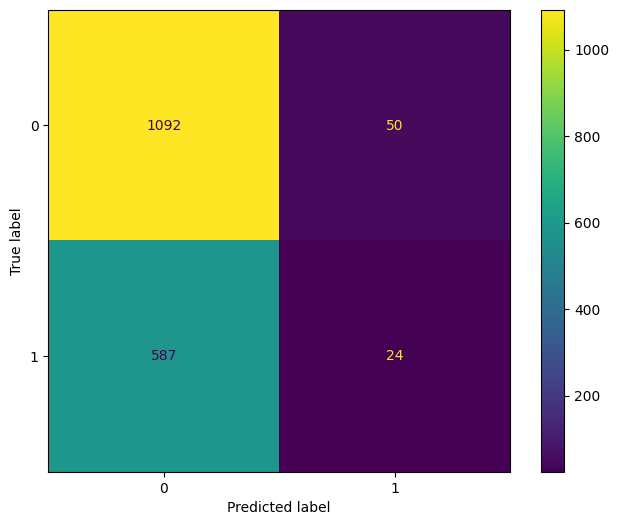

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay

# Change figure size and increase dpi for better resolution
# and get reference to axes object
fig, ax = plt.subplots(figsize=(8,6), dpi=100)

# initialize using the raw 2D confusion matrix 
# and output labels (in our case, it's 0 and 1)
display = ConfusionMatrixDisplay(conf_matrix)

#ax.set_xlabel("Predicted", labelpad=20)
#ax.set_ylabel("Actual", labelpad=20)

# show the plot. 
# Pass the parameter ax to show customizations (ex. title) 
display.plot(ax=ax)

In [16]:
import pickle

#output_file = f'regressionModel.bin'
output_file = f'logisticRegressionModel.bin'

with open(output_file, 'wb') as f_out:
    pickle.dump((logmodel2), f_out)

print(f'the model is saved to {output_file}')

the model is saved to logisticRegressionModel.bin


In [18]:
output_file = f'xgBoostModel.bin'
with open(output_file, 'wb') as f_out:
    pickle.dump((xgbModel2), f_out)

print(f'the model is saved to {output_file}')

the model is saved to xgBoostModel.bin
